# Using Google Trends as Predictor of JETS ETF

## Installing & Loading Necessary Packages 


In [1]:
install.packages("rvest") #A Web-Scrapping Package
install.packages("magrittr")
install.packages("stringr")
install.packages("quantmod")
install.packages("RMySQL")
install.packages("dplyr")

library(rvest)
library(magrittr)
library(stringr)
library(quantmod)
library(RMySQL)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: DBI


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The foll

## Loading the scrapped data from Google Trends and Alexarank

In [2]:
queryMySQL = function(statement) {
  con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7")
  response = dbGetQuery(con,statement)
  dbDisconnect(con)

  return(response)  
}

queryMySQL("show tables in writeable_fina_4359_u3548379")

#lapply(dbListConnections(dbDriver( drv = "MySQL")), dbDisconnect)

Tables_in_writeable_fina_4359_u3548379
<chr>
JETS
TSA
alexarank_daily_by_individual_companies
alexarank_daily_cummulative
alexarank_weekly_cummulative
google_trends_weekly_data
visits


In [3]:
con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7", dbname = "writeable_fina_4359_u3548379")
g_trends = queryMySQL("select * from writeable_fina_4359_u3548379.google_trends_weekly_data")

In [4]:
g_trends$date = substr(g_trends$date,1,10)
g_trends$date = as.Date(g_trends$date)
head(g_trends)

,date,Tripadvisor,Booking,Trip,Expedia,Hotels,Airbnb,Agoda,Priceline,Skyscanner,Trivago,Average,Sum
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-05-23,78,54,8,85,81,56,85,92,52,54,64.5,645
2,2016-05-30,81,57,11,84,81,55,85,89,52,53,64.8,648
3,2016-06-06,80,57,9,86,82,59,84,95,52,56,66.0,660
4,2016-06-13,81,59,8,88,83,57,80,95,52,59,66.2,662
5,2016-06-20,82,61,9,93,91,61,81,95,57,61,69.1,691
6,2016-06-27,86,67,10,95,100,62,86,100,60,71,73.7,737


## Downloading JETS ETF Data

In [5]:
getSymbols("JETS")
ticker = JETS[,-c(1:5)]
colnames(ticker)[1] = "price"

adj_JETS = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(ticker)) {
  adj_JETS[num_row,1] = index(ticker)[num_row]
  adj_JETS[num_row,2] = ticker[num_row,1]
}

tail(adj_JETS)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "JETS"

,date,price
,<date>,<dbl>
1523,2021-05-17,26.55
1524,2021-05-18,26.57
1525,2021-05-19,26.27
1526,2021-05-20,26.03
1527,2021-05-21,25.94
1528,2021-05-24,26.31


## Downloading S&P 500 Data

In [6]:
getSymbols("^GSPC")

SPX = GSPC[,-c(1:5)]
colnames(SPX)[1] = "price"

adj_SPX = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(SPX)) {
  adj_SPX[num_row,1] = index(SPX)[num_row]
  adj_SPX[num_row,2] = SPX[num_row,1]
}

tail(adj_SPX)

[1] "^GSPC"

,date,price
,<date>,<dbl>
3618,2021-05-17,4163.29
3619,2021-05-18,4127.83
3620,2021-05-19,4115.68
3621,2021-05-20,4159.12
3622,2021-05-21,4155.86
3623,2021-05-24,4197.05


## Downloading Risk-Free Rate (10Y US Govn't Treasuries Yield)

In [7]:
getSymbols("DGS10", src = "FRED")

rf = data.frame(date = as.Date("1990-01-01"), yield = 0)


for (num_row in 1:nrow(DGS10)) {
  rf[num_row,1] = index(DGS10)[num_row]
  rf[num_row,2] = DGS10[num_row,1]
}

#Linearly Interpolating Missing Value
  
for (num_row in 2:nrow(rf)) {
  if (is.na(rf[num_row,2]) == TRUE) {
    rf[num_row,2] = (rf[num_row-1,2] + rf[num_row+1,2])/2
  }
}

head(rf)

[1] "DGS10"

,date,yield
,<date>,<dbl>
1,1962-01-02,4.06
2,1962-01-03,4.03
3,1962-01-04,3.99
4,1962-01-05,4.02
5,1962-01-08,4.03
6,1962-01-09,4.05


## Merging Daily JETS ETF Data & Google Trends Data 

In [8]:
g_trends_cummulative = g_trends %>% select(date, Average, Sum)
head(g_trends_cummulative)

,date,Average,Sum
,<date>,<dbl>,<dbl>
1,2016-05-23,64.5,645
2,2016-05-30,64.8,648
3,2016-06-06,66.0,660
4,2016-06-13,66.2,662
5,2016-06-20,69.1,691
6,2016-06-27,73.7,737


In [9]:
merge(adj_JETS, g_trends_cummulative, by = "date", all.x = TRUE) %>% merge(adj_SPX, by = "date", all.x = TRUE) %>% merge(rf, by = "date", all.x = TRUE) -> regression_data
colnames(regression_data)[c(2,5)] = c("JETS_price", "SPX")
head(regression_data)

,date,JETS_price,Average,Sum,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015-04-30,23.19987,NA,NA,2085.51,2.05
2,2015-05-01,23.85401,NA,NA,2108.29,2.12
3,2015-05-04,23.65258,NA,NA,2114.49,2.16
4,2015-05-05,23.01955,NA,NA,2089.46,2.19
5,2015-05-06,23.00037,NA,NA,2080.15,2.25
6,2015-05-07,23.44157,NA,NA,2088.00,2.18


## Transform Daily Data into Weekly Data

In [10]:
temp_JETS <- as.xts(regression_data$JETS_price, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_JETS <- temp_JETS["2019-12-23/2021"]

temp_SPX <- as.xts(regression_data$SPX, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_SPX <- temp_SPX["2019-12-23/2021"]

temp_yield <- as.xts(regression_data$yield, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof")
temp_yield <- temp_yield["2019-12-23/2021"]

temp_g_trends <- as.xts(g_trends_cummulative$Sum, order.by = as.Date(g_trends_cummulative$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends <- temp_g_trends["2019-12-23/2021"]

temp_g_trends_avg <- as.xts(g_trends_cummulative$Average, order.by = as.Date(g_trends_cummulative$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends_avg <- temp_g_trends_avg["2019-12-23/2021"]

regression_data_weekly = data.frame(date = as.Date("1990-01-01"), JETS_closing_price = 0, Google_Trends_Sum =0, Google_Trends_Avg =0, SPX = 0, yield = 0)

for (i in 1:nrow(temp_g_trends)) {
  regression_data_weekly[i,1] = index(temp_g_trends)[i]  
  regression_data_weekly[i,2] = temp_JETS[i,4]
  regression_data_weekly[i,3] = temp_g_trends[i,1]
  regression_data_weekly[i,4] = temp_g_trends_avg[i,1]
  regression_data_weekly[i,5] = temp_SPX[i,1]
  regression_data_weekly[i,6] = temp_yield[i,1]
}

if (Sys.Date() >= regression_data_weekly[nrow(temp_g_trends),1]) {
  regression_data_weekly <- regression_data_weekly[-nrow(temp_g_trends),]
}

head(regression_data_weekly,200)

#Consider trying 2020-04-06

Warning message in to.period(x, "weeks", name = name, ...):
“missing values removed from data”


,date,JETS_closing_price,Google_Trends_Sum,Google_Trends_Avg,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-23,31.60126,639,63.9,3224.01,1.93
2,2019-12-30,31.15744,708,70.8,3221.29,1.90
3,2020-01-06,31.34636,727,72.7,3246.28,1.81
4,2020-01-13,32.23700,722,72.2,3288.13,1.85
5,2020-01-20,31.26839,680,68.0,3320.79,1.78
6,2020-01-27,29.82797,645,64.5,3243.63,1.61
7,2020-02-03,30.79758,636,63.6,3248.92,1.54
8,2020-02-10,31.32137,636,63.6,3352.09,1.56
9,2020-02-17,30.42973,632,63.2,3370.29,1.55


# Prepare Data for Regression and Regreesion

In [11]:
to_regress = data.frame(date = as.Date("1990-01-01"), JETS_weekly_return = 0, Google_Trends_Weekly_Change =0, SPX_weekly_return = 0,JETS_weekly_excess_return=0,	SPX_weekly_excess_return =0, JETS_rebased = 0, Google_Trends_rebased=0, SPX_rebased=0)
for(i in 1:nrow(regression_data_weekly))
{
   if (i == 1) {
      to_regress[i,1] = regression_data_weekly[i,1]
      to_regress[i,7] = 1
      to_regress[i,8] = 1
      to_regress[i,9] = 1
    } 
    else{
 to_regress[i,1] = regression_data_weekly[i,1]
 to_regress[i,2] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2]
 to_regress[i,3] = (regression_data_weekly[i,3]-regression_data_weekly[i-1,3])/regression_data_weekly[i-1,3]
 #to_regress[i,4] = (regression_data_weekly[i,4]-regression_data_weekly[i-1,4])/regression_data_weekly[i-1,4]
 to_regress[i,4] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5]
 to_regress[i,5] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2] - regression_data_weekly[i,6]/52/100
 to_regress[i,6] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5] - regression_data_weekly[i,6]/52/100
 to_regress[i,7] = to_regress[i-1,7] * (1 + to_regress[i,2])
 to_regress[i,8] = to_regress[i-1,8] * (1 + to_regress[i,3])
 to_regress[i,9] = to_regress[i-1,9] * (1 + to_regress[i,4])
    }
}
head(to_regress)

,date,JETS_weekly_return,Google_Trends_Weekly_Change,SPX_weekly_return,JETS_weekly_excess_return,SPX_weekly_excess_return,JETS_rebased,Google_Trends_rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-23,0.000000000,0.000000000,0.0000000000,0.000000000,0.000000000,1.0000000,1.000000,1.0000000
2,2019-12-30,-0.014044472,0.107981221,-0.0008436608,-0.014409857,-0.001209045,0.9859555,1.107981,0.9991563
3,2020-01-06,0.006063496,0.026836158,0.0077577584,0.005715419,0.007409682,0.9919339,1.137715,1.0069076
4,2020-01-13,0.028412997,-0.006877579,0.0128916340,0.028057228,0.012535865,1.0201177,1.129890,1.0198882
5,2020-01-20,-0.030046528,-0.058171745,0.0099327451,-0.030388835,0.009590437,0.9894667,1.064163,1.0300185
6,2020-01-27,-0.046066358,-0.051470588,-0.0232354816,-0.046375974,-0.023545097,0.9438856,1.009390,1.0060855


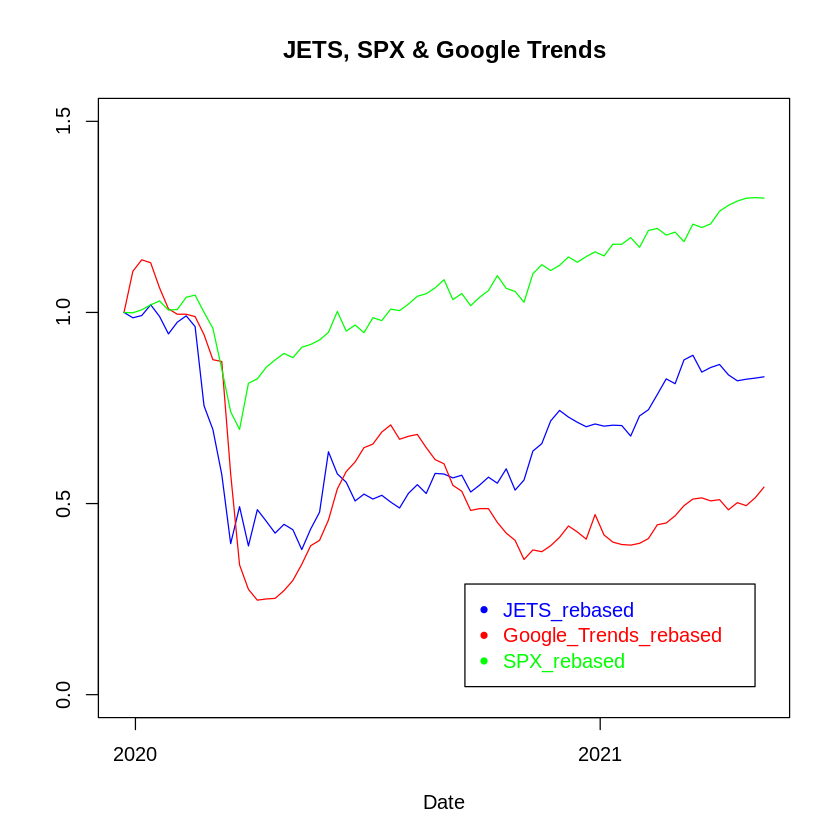

In [ ]:
plot(x = to_regress[,1], y = to_regress[,7], type = "l", col = "blue", ylim = c(0,1.5), xlab = "Date", ylab = "", main = "JETS, SPX & Google Trends")
lines(x = to_regress[,1], y = to_regress[,8], type = "l", col = "red")
lines(x = to_regress[,1], y = to_regress[,9], type = "l", col = "green")
legend("bottomright", 
        legend = colnames(to_regress)[7:9], 
        col = c("blue", "red", "green"),  
        pch = 20, 
        bty = "o", 
        pt.cex = 1, 
        cex = 1, 
        text.col = c("blue", "red", "green"), 
        inset = c(0.05, 0.05))

## Regressing Arithmetic Weekly JETS Return - CAPM


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27325 -0.03828 -0.00041  0.03402  0.32411 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.0004127  0.0110739   0.037    0.970
to_regress[, 6] 0.3152824  0.2928206   1.077    0.285

Residual standard error: 0.09406 on 71 degrees of freedom
Multiple R-squared:  0.01607,	Adjusted R-squared:  0.002208 
F-statistic: 1.159 on 1 and 71 DF,  p-value: 0.2853


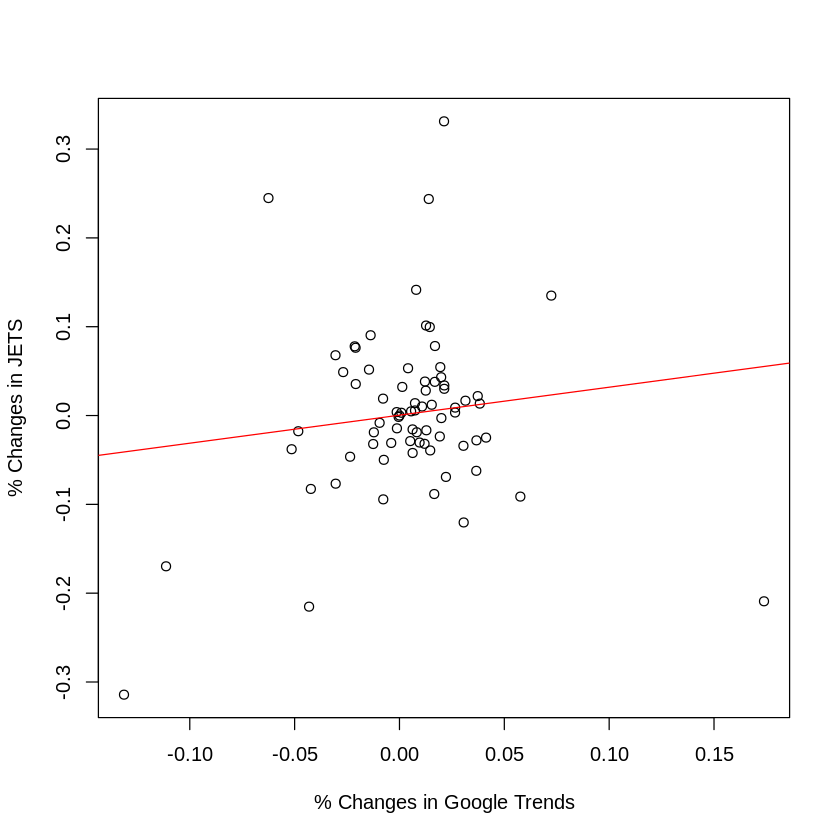

In [15]:
lm_result_1 = lm(to_regress[,5] ~ to_regress[,6]) # i.e. CAPM
summary(lm_result_1)

plot(to_regress[,5] ~ to_regress[,6], xlab = "% Changes in Google Trends", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly JETS Return - Google Trends

In [14]:
lm_result_2 = lm(to_regress[,5] ~ to_regress[,3])
summary(lm_result_2)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 3])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26015 -0.03793 -0.00218  0.03226  0.31138 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.002285   0.010956   0.209    0.835
to_regress[, 3] 0.167061   0.119368   1.400    0.166

Residual standard error: 0.09354 on 71 degrees of freedom
Multiple R-squared:  0.02685,	Adjusted R-squared:  0.01314 
F-statistic: 1.959 on 1 and 71 DF,  p-value: 0.166


## Regressing Arithmetic Weekly JETS Return - "Improved CAPM with Google Trends"

In [13]:
lm_result_3 = lm(to_regress[,5] ~ to_regress[,6] + to_regress[,3]) #"Improved Version 1"
summary(lm_result_3)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6] + to_regress[, 
    3])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.240503 -0.037695 -0.000948  0.032561  0.314590 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.001332   0.011085   0.120    0.905
to_regress[, 6] 0.210121   0.307082   0.684    0.496
to_regress[, 3] 0.140668   0.125873   1.118    0.268

Residual standard error: 0.09389 on 70 degrees of freedom
Multiple R-squared:  0.03331,	Adjusted R-squared:  0.005693 
F-statistic: 1.206 on 2 and 70 DF,  p-value: 0.3055
